In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# standard imports
import tensorrt #For GPU
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
import random
from sklearn import preprocessing
from keras.callbacks import History
import matplotlib.pyplot as plt
import np_utils
import os
from tensorflow.keras.optimizers import Adam
from plain_neural_network import*
from keras import backend as K


%matplotlib inline

2023-10-28 02:55:35.954777: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2852918418077026974
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 45610434560
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 13743557174040056251
physical_device_desc: "device: 0, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-10-28 02:59:44.368224: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 43497 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6


In [ ]:
# input_dir = "/albedo/home/ssunar/CNN_eddy_detection/for_paper/interpolation/south_atlantic"
# input_file_paths = sorted(
#     [
#         os.path.join(input_dir, fname)
#         for fname in os.listdir(input_dir)
#     ])
# #input_file_paths.pop(29)
# #input_file_paths.pop(11)

# data_x = xr.open_mfdataset(input_file_paths,combine = 'nested', concat_dim="TIME")
# data_x = data_x.ssh.to_numpy()
# X = np.float32(data_x)
                            
# X[X>1000] = 0
# print(X.shape)

In [ ]:
# from matplotlib import cm
# fig, ax = plt.subplots( 1, 1, )
# ax.pcolormesh(data_long,data_lat,np.transpose(X[0,:,:]), cmap=cm.seismic, vmin=-1, vmax=1)

In [ ]:
# input_dir = "/albedo/home/ssunar/CNN_eddy_detection/for_paper/segmentation_masks/south_atlantic"
# input_file_paths = sorted(
#     [
#         os.path.join(input_dir, fname)
#         for fname in os.listdir(input_dir)
#     ])
# #input_file_paths.pop(29)
# #input_file_paths.pop(11)

# data_y = xr.open_mfdataset(input_file_paths,combine = 'nested', concat_dim="TIME")
# data_y = data_y.seg_mask.to_numpy()
# Y = np.float32(data_y)


# (Y.shape)

In [ ]:
import glob
input_dir = "/albedo/work/user/ssunar/for_paper/segmentation_masks/south_atlantic/"
input_file_paths = sorted(glob.glob(input_dir+'*.nc'))
data = xr.open_mfdataset(input_file_paths,combine = 'nested', concat_dim="TIME").astype('float32')
X = data.ssh.to_numpy()
Y = data.seg_mask.to_numpy()
X[X>1000] = 0

X.shape
Y.shape

In [4]:
data

<xarray.Dataset>
Dimensions:    (TIME: 4017, LONGITUDE: 840, LATITUDE: 480)
Coordinates:
  * LONGITUDE  (LONGITUDE) float32 -70.0 -69.92 -69.83 ... -0.1667 -0.08333
  * LATITUDE   (LATITUDE) float32 -60.0 -59.92 -59.83 ... -20.25 -20.17 -20.08
  * TIME       (TIME) float32 5.172e+05 5.172e+05 ... 6.136e+05 6.136e+05
Data variables:
    ssh        (TIME, LONGITUDE, LATITUDE) float32 dask.array<chunksize=(31, 840, 480), meta=np.ndarray>
    seg_mask   (TIME, LONGITUDE, LATITUDE) float32 dask.array<chunksize=(31, 840, 480), meta=np.ndarray>

In [5]:
data_long = data.LONGITUDE
data_lat = data.LATITUDE
xx, yy = np.meshgrid(data_long, data_lat)

/tmp/ipykernel_3674215/3071145902.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(data_long,data_lat,np.transpose(X[100,:,:]), cmap=cm.seismic, vmin=-1, vmax=1)


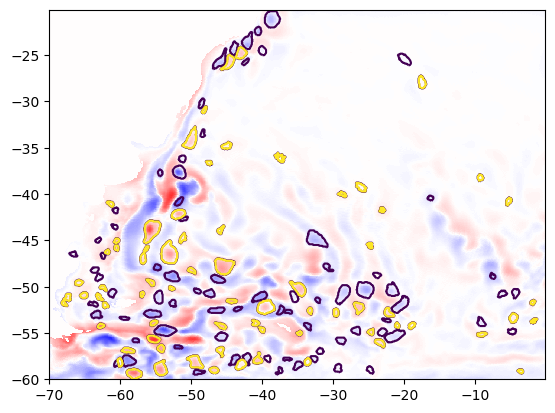

In [6]:
from matplotlib import cm
fig, ax = plt.subplots( 1, 1, )
ax.pcolormesh(data_long,data_lat,np.transpose(X[100,:,:]), cmap=cm.seismic, vmin=-1, vmax=1)
ax.contour(xx, yy, np.transpose(Y[100,:,:]), levels=[0,1])

In [7]:
Y[(Y != 1) & (Y!=2)] = 0

In [8]:
def split_3d_vector(vector):
    X, Y, Z = vector.shape
    chunks = []
    
    for i in range(X):
        vector_2d = vector[i,:,:]
        B = Y // 256 + 1
        for b in range(B):
            start_y = b * 256
            end_y = (b + 1) * 256
            if end_y > Y:
                start_y = Y - 256
                end_y = Y
      
            C = Z // 256 + 1
            for c in range(C):
                start_z = c * 256
                end_z = (c + 1) * 256
                if end_z > Z:
                    start_z = Z - 256
                    end_z = Z
                final_chunk = vector_2d[start_y:end_y, start_z:end_z]
                chunks.append(final_chunk)
    return chunks

In [9]:
new_X = np.array(split_3d_vector(X))
new_Y = np.array(split_3d_vector(Y))

data_x = new_X
data_y = new_Y

(data_x.shape)
(data_y.shape)

(32136, 256, 256)

(32136, 256, 256)

In [10]:
img_size = (256, 256)
num_classes = 3
batch_size = 16
epochs = 60
total_samples = len(data_x)-1000
# if len(data_x) > 4000:
#     total_samples = 4000
# else:
#     total_samples = len(data_x)
print(total_samples)

31136


In [11]:
model = get_model(img_size, num_classes)
model.summary()

2023-10-28 03:01:16.007659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43497 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:41:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 separable_conv2d (Separabl  (None, 256, 256, 8)          17        ['input_1[0][0]']             
 eConv2D)                                                                                         
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 8)          32        ['separable_conv2d[0][0]']    
 Normalization)                                                                                   
                                                                                              

 bleConv2D)                                                                                       
                                                                                                  
 batch_normalization_7 (Bat  (None, 32, 32, 32)           128       ['separable_conv2d_7[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 activation_7 (Activation)   (None, 32, 32, 32)           0         ['batch_normalization_7[0][0]'
                                                                    ]                             
                                                                                                  
 dropout_3 (Dropout)         (None, 32, 32, 32)           0         ['activation_7[0][0]']        
                                                                                                  
 up_sampli

 activation_13 (Activation)  (None, 256, 256, 8)          0         ['batch_normalization_13[0][0]
                                                                    ']                            
                                                                                                  
 dropout_6 (Dropout)         (None, 256, 256, 8)          0         ['activation_13[0][0]']       
                                                                                                  
 separable_conv2d_14 (Separ  (None, 256, 256, 3)          32        ['dropout_6[0][0]']           
 ableConv2D)                                                                                      
                                                                                                  
 reshape (Reshape)           (None, 65536, 3)             0         ['separable_conv2d_14[0][0]'] 
                                                                                                  
 activatio

In [12]:
#Loss function 
#defined from the paper:
#Santana et al._2020_Neural network training for the detection and classification of oceanic mesoscale eddies

unique, counts = np.unique(data_y, return_counts=True)
dict(zip(unique, counts))

freq = [np.sum(counts)/j for j in counts]
weightsSeg = [f/np.sum(freq) for f in freq]
print(weightsSeg)

def dice_coef_anti(y_true, y_pred):
    smooth = 1.  # to avoid zero division
    y_true_anti = y_true[:,:,1]
    y_pred_anti = y_pred[:,:,1]
    intersection_anti = K.sum(y_true_anti * y_pred_anti)
    return (2 * intersection_anti + smooth) / (K.sum(y_true_anti)+ K.sum(y_pred_anti) + smooth)

def dice_coef_cyc(y_true, y_pred):
    smooth = 1.  # to avoid zero division
    y_true_cyc = y_true[:,:,2]
    y_pred_cyc = y_pred[:,:,2]
    intersection_cyc = K.sum(y_true_cyc * y_pred_cyc)
    return (2 * intersection_cyc + smooth) / (K.sum(y_true_cyc) + K.sum(y_pred_cyc) + smooth)

def dice_coef_nn(y_true, y_pred):
    smooth = 1.  # to avoid zero division
    y_true_nn = y_true[:,:,0]
    y_pred_nn = y_pred[:,:,0]
    intersection_nn = K.sum(y_true_nn * y_pred_nn)
    return (2 * intersection_nn + smooth) / (K.sum(y_true_nn) + K.sum(y_pred_nn) + smooth)
    
def mean_dice_coef(y_true, y_pred):
    return (dice_coef_anti(y_true, y_pred) + dice_coef_cyc(y_true, y_pred) + dice_coef_nn(y_true, y_pred))/3.

def weighted_mean_dice_coef(y_true, y_pred):
    #return (weightsSeg[2]*dice_coef_anti(y_true, y_pred) + weightsSeg[1]*dice_coef_cyc(y_true, y_pred) + weightsSeg[0]*dice_coef_nn(y_true, y_pred))
    return (weightsSeg[2]*dice_coef_anti(y_true, y_pred) + weightsSeg[1]*dice_coef_cyc(y_true, y_pred) + weightsSeg[0]*dice_coef_nn(y_true, y_pred))
      
def dice_coef_loss(y_true, y_pred):
    return 1 - weighted_mean_dice_coef(y_true, y_pred)

{0.0: 1904815373, 1.0: 104900298, 2.0: 96349225}

[0.02568828581339181, 0.46645665128011865, 0.5078550629064896]


In [13]:
# Split our img paths into a training and a validation set
split = 0.3
train_samples = int((1-split)*total_samples)
#same seed must be used
random.Random(0).shuffle(data_x)
random.Random(0).shuffle(data_y)
train_input = data_x[0:train_samples]
train_target = data_y[0:train_samples]
val_input = data_x[train_samples:total_samples]
val_target = data_y[train_samples:total_samples]

print("train_input:", train_input.shape)
print("val_input:", val_input.shape)

# Instantiate data Sequences for each split
train_gen = plain_net_eddy(batch_size, img_size, train_input, train_target)
val_gen = plain_net_eddy(batch_size, img_size, val_input, val_target)
print("Size of each batch: ",train_gen[1][0].shape)

train_input: (21795, 256, 256)
val_input: (9341, 256, 256)
Size of each batch:  (16, 256, 256, 1)


In [14]:
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/albedo/soft/sw/spack-sw/cuda/11.7.0-qk7q7bh/'
os.environ['XLA_FLAGS']
# print(os.environ.get('CUDA_HOME'))

'--xla_gpu_cuda_data_dir=/albedo/soft/sw/spack-sw/cuda/11.7.0-qk7q7bh/'

In [15]:
file_path_save = "/albedo/work/user/ssunar/for_paper/unet_trained/south_atlantic/train"
os.makedirs(file_path_save, exist_ok=True)
model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=['categorical_accuracy', mean_dice_coef, weighted_mean_dice_coef])

callbacks = [keras.callbacks.ModelCheckpoint(file_path_save, save_best_only=True , monitor='val_loss',save_weights_only=True, save_freq="epoch"),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=1e-30, min_lr=1e-30)]

# Train the model, doing validation at the end of each epoch.
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks, shuffle=True,verbose=1)

Epoch 1/60


2023-10-28 03:02:31.135325: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-28 03:02:33.358185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-10-28 03:04:18.475099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-28 03:04:28.204556: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x15403f001b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-28 03:04:28.204594: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2023-10-28 03:04:28.326355: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disablin

1362/1362 [==============================] - 268s 103ms/step - loss: 0.6325 - categorical_accuracy: 0.7127 - mean_dice_coef: 0.5039 - weighted_mean_dice_coef: 0.3675 - val_loss: 0.5299 - val_categorical_accuracy: 0.8992 - val_mean_dice_coef: 0.6190 - val_weighted_mean_dice_coef: 0.4701 - lr: 0.0010
Epoch 2/60
1362/1362 [==============================] - 140s 103ms/step - loss: 0.5013 - categorical_accuracy: 0.9118 - mean_dice_coef: 0.6405 - weighted_mean_dice_coef: 0.4987 - val_loss: 0.5371 - val_categorical_accuracy: 0.9171 - val_mean_dice_coef: 0.6177 - val_weighted_mean_dice_coef: 0.4629 - lr: 0.0010
Epoch 3/60
1362/1362 [==============================] - 141s 103ms/step - loss: 0.4796 - categorical_accuracy: 0.9168 - mean_dice_coef: 0.6565 - weighted_mean_dice_coef: 0.5204 - val_loss: 0.4609 - val_categorical_accuracy: 0.9087 - val_mean_dice_coef: 0.6675 - val_weighted_mean_dice_coef: 0.5391 - lr: 0.0010
Epoch 4/60
1362/1362 [==============================] - 139s 102ms/step - loss

1362/1362 [==============================] - 139s 102ms/step - loss: 0.3974 - categorical_accuracy: 0.9321 - mean_dice_coef: 0.7159 - weighted_mean_dice_coef: 0.6026 - val_loss: 0.3870 - val_categorical_accuracy: 0.9174 - val_mean_dice_coef: 0.7202 - val_weighted_mean_dice_coef: 0.6130 - lr: 2.5000e-04
Epoch 52/60
1362/1362 [==============================] - 140s 102ms/step - loss: 0.3971 - categorical_accuracy: 0.9323 - mean_dice_coef: 0.7161 - weighted_mean_dice_coef: 0.6029 - val_loss: 0.3819 - val_categorical_accuracy: 0.9181 - val_mean_dice_coef: 0.7237 - val_weighted_mean_dice_coef: 0.6181 - lr: 2.5000e-04
Epoch 53/60
1362/1362 [==============================] - 139s 102ms/step - loss: 0.3969 - categorical_accuracy: 0.9322 - mean_dice_coef: 0.7162 - weighted_mean_dice_coef: 0.6031 - val_loss: 0.3817 - val_categorical_accuracy: 0.9185 - val_mean_dice_coef: 0.7239 - val_weighted_mean_dice_coef: 0.6183 - lr: 2.5000e-04
Epoch 54/60
1362/1362 [==============================] - 139s 10

In [16]:
model.save_weights(file_path_save + '/weights.h5')

<Figure size 1000x1000 with 0 Axes>

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

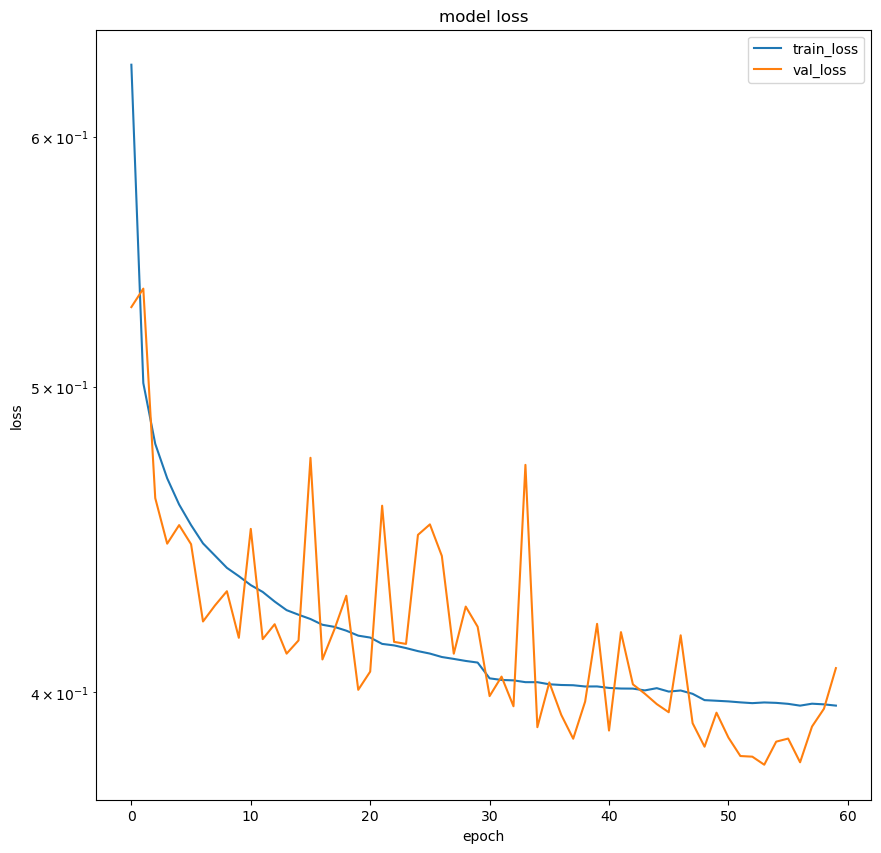

In [17]:
dir_path = "/albedo/work/user/ssunar/for_paper/unet_trained/south_atlantic/train"
plt.figure(figsize=(10, 10))
plt.semilogy(model.history.history['loss'])
plt.semilogy(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right');
plt.savefig(dir_path + "loss_graph.png", dpi = 300)

In [18]:
import time
from sklearn.metrics import classification_report
start = time.time()
val_gen = plain_net_eddy(batch_size, img_size, val_input, val_target)
val_preds = model.predict(val_gen)
print(val_preds.shape)

end = time.time()
time_per_img = (end - start)/val_preds.shape[0]
print("Time Per image:",time_per_img)
print("Time for 1 year eqv:",time_per_img*365)

583/583 [==============================] - 12s 18ms/step
(9328, 65536, 3)
Time Per image: 0.0018071244450008073
Time for 1 year eqv: 0.6596004224252947


In [19]:
# Since we do not use all samples for training.
if len(data_x) > total_samples + 1000:
    test_size = 1000
    test_inp = data_x[total_samples : total_samples+test_size]
    test_seg = data_y[total_samples : total_samples+test_size]
elif len(data_x) > total_samples:
    test_size = len(data_x) - total_samples
    test_inp = data_x[total_samples : total_samples+test_size]
    test_seg = data_y[total_samples : total_samples+test_size]
else:
    test_inp = val_input
    test_seg = val_target
    test_size = len(test_inp)
    
test_inp.shape
test_seg.shape

(1000, 256, 256)

(1000, 256, 256)

In [20]:
# convert test segmentation mask into catagorical form
categorical_test_seg = to_categorical(test_seg)
categorical_test_seg.shape

(1000, 256, 256, 3)

In [21]:
# Prediction on test data
test_inp = np.reshape(test_inp,(len(test_inp),img_size[0],img_size[1],1))
catagorical_test_preds = model.predict(test_inp)

32/32 [==============================] - 7s 15ms/step


In [22]:
model.evaluate(test_inp, catagorical_test_preds)

32/32 [==============================] - 1s 21ms/step - loss: 0.0037 - categorical_accuracy: 1.0000 - mean_dice_coef: 0.9973 - weighted_mean_dice_coef: 0.9963


[0.003708057338371873, 1.0, 0.9973307847976685, 0.9962892532348633]

In [23]:
mask = np.argmax(np.reshape(catagorical_test_preds[70],(1,img_size[1],img_size[0],3)), axis=-1)
mask = np.reshape(mask,(img_size[0],img_size[1]))

<Figure size 2000x1000 with 0 Axes>

<AxesSubplot:>

(-0.5, 255.5, 255.5, -0.5)

Text(0.5, 1.0, 'Result Segmentation')

<AxesSubplot:>

(-0.5, 255.5, 255.5, -0.5)

Text(0.5, 1.0, 'Groundtruth Segmentation')

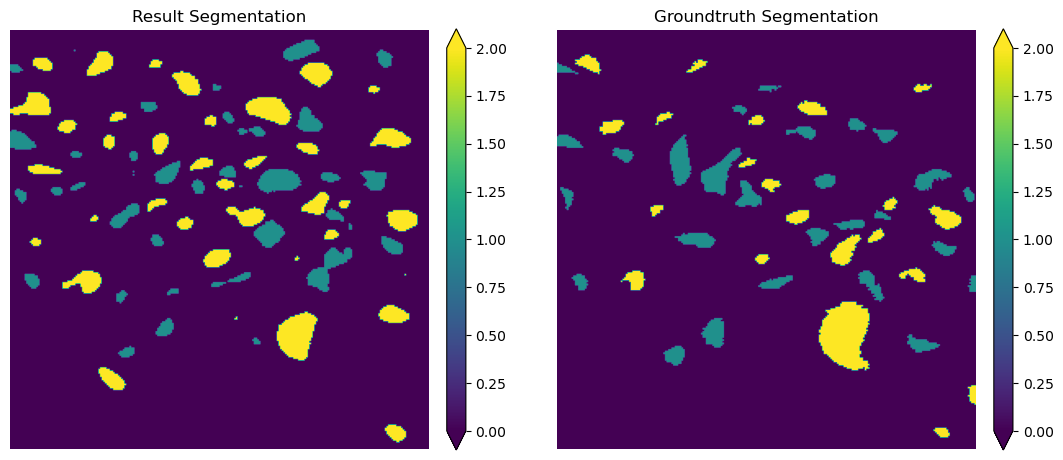

In [24]:
#seeing the prediction of one image of the validation set
%matplotlib inline

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(mask.T, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
plt.axis('off')
plt.title('Result Segmentation');
plt.savefig(dir_path + "prediction.png", dpi = 300)

plt.subplot(132)
plt.imshow(test_seg[70].T, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
plt.axis('off')
plt.title('Groundtruth Segmentation');
plt.savefig(dir_path + "groundtruth.png", dpi = 300)